<a href="https://colab.research.google.com/github/alexvaroz/data_science_alem_do_basico/blob/master/Classificacao_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

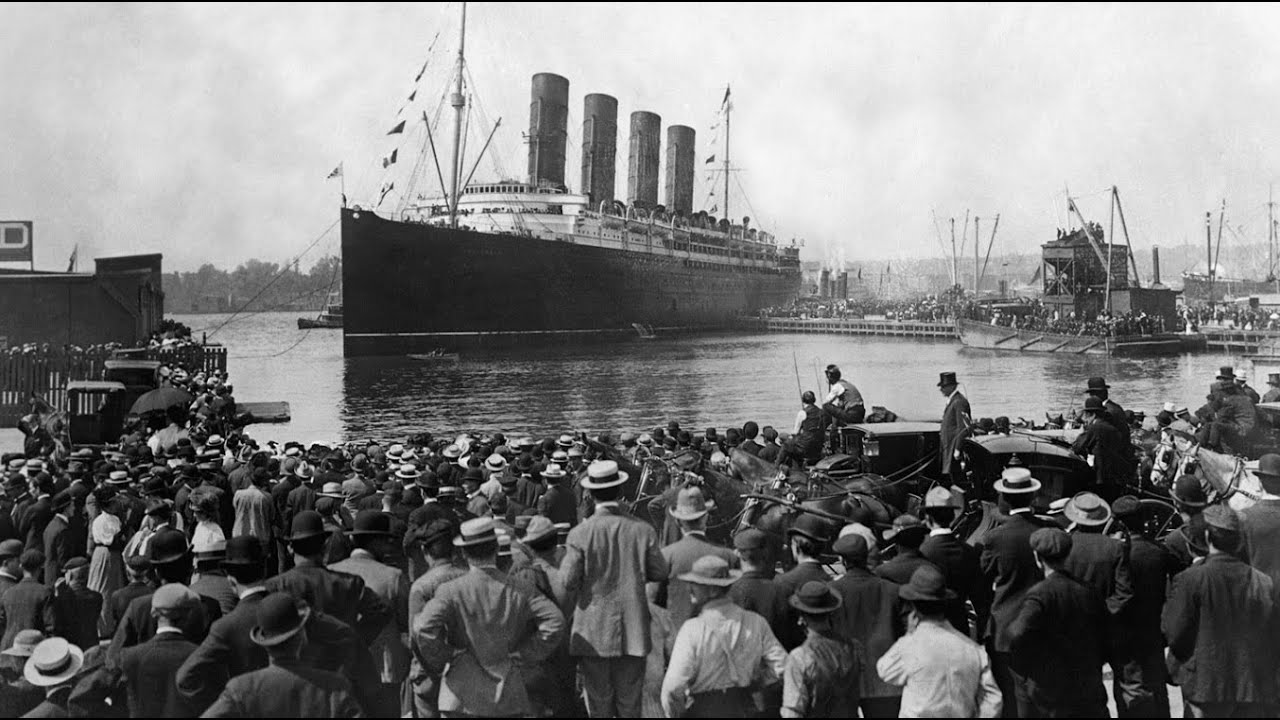

# **Classificação das Vítimas do naufrágio do Titanic**

Este notebook é mais uma versão de um dos datasets mais conhecidos e utilizados no aprendizado de ciência de dados. Trata-se do desafio de se prever quais passageiros que sobreviveram após embarcarem na viagem inaugural do dito "inafundável" navio chamado Titanic.

Para contextualizar, seguem [informações](https://pt.wikipedia.org/wiki/RMS_Titanic) do desastre histórico:

*A embarcação partiu em sua viagem inaugural de Southampton com destino a Nova Iorque em 10 de abril de 1912, no caminho passando em Cherbourg-Octeville, na França, e por Queenstown, na Irlanda. Colidiu com um iceberg na proa dianteira do lado direito às 23h40 de 14 de abril, naufragando na madrugada do dia seguinte, com mais de 1 500 pessoas a bordo, sendo um dos maiores desastres marítimos em tempos de paz de toda a história. Seu naufrágio destacou vários pontos fracos do projeto, deficiências nos procedimentos de evacuação de emergência e falhas nas regulamentações marítimas.* 

Dez em cada dez cientistas de dados conhecem este dataset devido a ser utilizado em uma competição para iniciantes no [Kaggle](https://www.kaggle.com/c/titanic).

Neste notebook, utilizaremos o dataset disponibilizado no Kaggle, e procuraremos demonstrar o passo a passo para a construção e avaliação de um modelo de classificação.

In [1]:
# Importação das bibliotecas
import os
import urllib.request
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile

## **1. Obtenção dos dados**

Os dados serão obtidos via download diretamente de um repositório e armazenados em uma pasta específica. Como o plano original é executar este notebook no ambiente do Colab, essa pasta será criada no sistema de arquivos da máquina virtual, implicando dizer que ela não é aproveitada em uma execução posterior do notebook, fato que seria diferente se houvesse a utilização do Drive pessoal, no qual a pasta seria persistida de forma permanente.

Se o notebook for executado em um ambiente local, a pasta será criada no mesmo diretório onde o notebook está sendo executado.

Para essa etapa serão criadas funções para realizarem as etapas de obtenção e carga dos dados em um dataframe Pandas.

A utilização de funções é muito importante para possibilitar uma automação do processo de obtenção e tratamento dos dados e, consequentemente, geração do modelo.

In [2]:
DOWNLOAD_URL = "https://github.com/alexvaroz/data_science_alem_do_basico/raw/master/titanic.zip"
DATASET_PATH = "/content/dataset_titanic"

# Função para obtenção dos dados
def fetch_data(download_url=DOWNLOAD_URL, dataset_path=DATASET_PATH):
    os.makedirs(dataset_path, exist_ok=True) # cria o diretório
    zip_path = os.path.join(dataset_path, "titanic.zip")
    urllib.request.urlretrieve(download_url, zip_path)
    files = ZipFile(zip_path,'r')
    files.extractall()
    files.close()

# Função para carregar os dados de treinamento em um dataframe pandas
def load_data_train(file_name = "train.csv"):
    csv_path = os.path.join(file_name)
    return pd.read_csv(csv_path)

# Função para carregar os dados de teste em um dataframe pandas
def load_data_test(file_name = "test.csv"):
    csv_path = os.path.join(file_name)
    return pd.read_csv(csv_path)

Como o dataset foi preparado para uma competição do Kaggle, ele já foi previamente dividido em Treino(`train.csv`) e Teste(`test.csv`). Nesse caso, vamos unir os dois datasets na exploração preliminar dos dados.

In [3]:
fetch_data()
df = load_data_train()
df_test = load_data_test()

df_merged = pd.concat(objs=[df, df_test], axis=0).reset_index(drop=True)

In [4]:
df_merged.shape

(1309, 12)

In [5]:
df_merged.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

As colunas apresentam a seguinte descrição:

* **PassengerId**: identificação do passageiro
* **Survived**: Se o tripulante sobreviveu ou não, **variável a ser predita**. 1 indica que sobreviveu e 0 que não sobreviveu.
* **Pclass**: Classe da passagem. 1 a 3, sendo 1 a melhor classe e 3 a pior classe. 
* **Name**: Nome do tripulante. 
* **Sex**: Gênero do tripulante.  
* **Age**: Idade do tripulante. 
* **SibSp**: Número de irmãos ou cônjuges a bordo.
* **Parch**: Número de pais ou filhos a bordo. 
* **Ticket**: Identificação do ticket 
* **Fare**: Valor da tarifa paga. 
* **Cabin**: Número da cabine do tripulante. 
* **Embarked**: Indicação do porto onte o tripulante embarcou.

O comando info() permite verificar a quantidade de dados faltantes em cada atributo. O atributo **Survived** apresenta uma grande quantidade de faltas por ser preenchido somente nos dados de Treino. Os demais atributos que possuem dados faltantes: **Age**, **Cabin**, **Fare** e **Embarked**, precisarão de algum tratamento para imputar dados. 

In [6]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


## **2. Análise exporatória**

Na análise exploratória, o foco será nos dados de treino, sempre considerando a relação dos diversos atributos com a variável a ser predita.

Iniciamos a análise com os atributos categóricos **Pclass**, **Sex** e **Embraked**, verificando a distribuição dos dados.

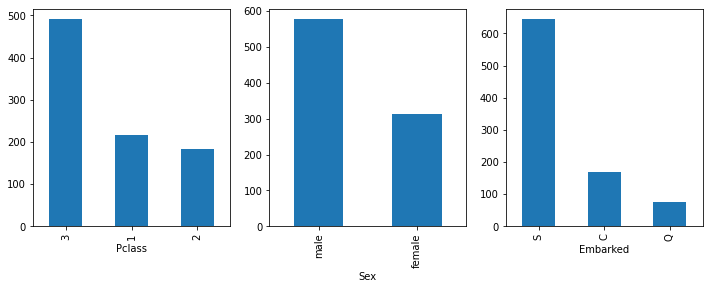

In [7]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3, figsize=(12,4))

df.Pclass.value_counts().plot.bar(ax=axis1,xlabel="Pclass")
df.Sex.value_counts().plot.bar(ax=axis2, xlabel="Sex")
df.Embarked.value_counts().plot.bar(ax=axis3,  xlabel="Embarked")

Com relação ao atributo **Pclass**, verifica-se que a categoria 3 é a mais populosa e, de acordo com a descrição, com piores instalações. Quanto ao atributo **Sex**, verifica-se que os homens eram grande maioria. Já com relação ao atributo **Embarked**, tem-se que a grande maioria dos passageiros embarcaram no porto de **Southampton**, o primeiro ponto de embarque.

Para entender melhor o **Embarked**, trazemos um trecho do [Wikipedia](https://pt.wikipedia.org/wiki/Naufr%C3%A1gio_do_RMS_Titanic) sobre o roteiro da viagem:

*A viagem inaugural do Titanic começou pouco depois das 10 horas da manhã de 10 de abril de 1912 quando deixou **Southampton** na primeira etapa de sua jornada até Nova Iorque. Poucas horas depois, chegou em **Cherbourg** no norte da França, uma jornada de 80 milhas náuticas (148 km ou 92 milhas), onde embarcou passageiros. Seu próximo porto foi **Queenstown** (agora Cobh) na Irlanda, que ele alcançaria por volta do meio-dia de 11 de abril. Partiu à tarde após embarcar mais passageiros e suprimentos para o navio.* 

Em seguida é hora de verificar a distribuição dos sobreviventes nessas categorias:

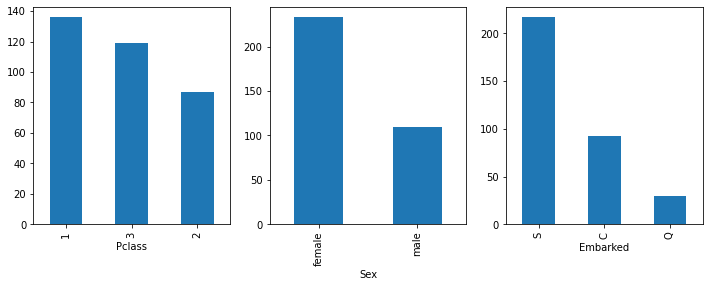

In [8]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3, figsize=(12,4))

df[(df.Survived == 1)].Pclass.value_counts().plot.bar(ax=axis1, xlabel="Pclass")
df[(df.Survived == 1)].Sex.value_counts().plot.bar(ax=axis2, xlabel="Sex")
df[(df.Survived == 1)].Embarked.value_counts().plot.bar(ax=axis3,  xlabel="Embarked")

Dos 3 atributos, o único que não sofreu alterações significativas foi o **Embarked**, que manteve o porto de Southampton como mais numeroso, entretanto com menor vantagem para os demais. O atributo mais afetado foi o **Sex**, visto que entre os sobreviventes, a grande maioria foi de mulheres, contrariando a distribuição incial. Com relação ao atributo **Pclass**, os passageiros da classe 1 são a maioria entre os sobreviventes, indicando a vantagem das melhores instalações.

Passemos aos atributos **SibSp**, que se refere à quantidade de irmãos ou conjuge a bordo, e **Parch**, que se refere à quantidade de filhos ou pais de cada passageiro.

Verifiquemos a distribuição dos valores entre os passageiros e em seguida com relação aos sobreviventes.


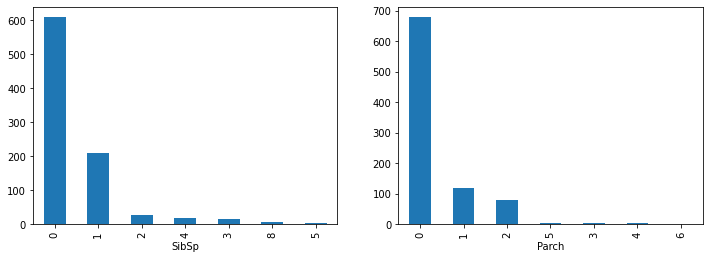

In [9]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(12,4))

df.SibSp.value_counts().plot.bar(ax=axis1, xlabel="SibSp")
df.Parch.value_counts().plot.bar(ax=axis2, xlabel="Parch")

De acordo com os dados, a grande maioria dos passageiros realizava a viagem sem acompanhantes. Entretanto, a diferença caiu bastante quando considerados somente os sobreviventes. Esse fato demonstra um potencial de influência desses atributos, que pode ser trabalhado para um aperfeiçoamento do modelo.

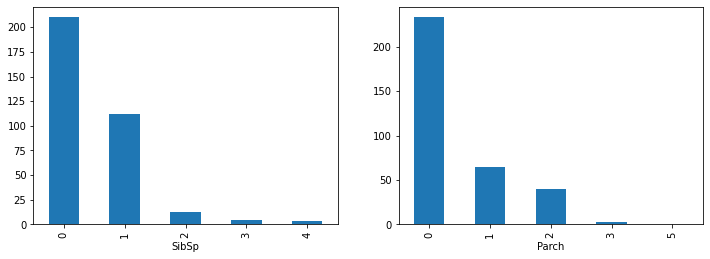

In [10]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(12,4))

df[(df.Survived == 1)].SibSp.value_counts().plot.bar(ax=axis1, xlabel="SibSp")
df[(df.Survived == 1)].Parch.value_counts().plot.bar(ax=axis2, xlabel="Parch")

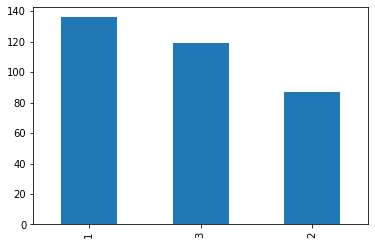

In [11]:
# Divisão das classes entre os sobreviventes
df[(df.Survived == 1)].Pclass.value_counts().plot.bar()

Com relação ao atributo **Ticket**, verifica-se a uma distribuição bem diversa dos valores, sem uma relação clara entre eles. Fato que prejudica a análise do atributo, concluindo-se pela sua remoção do modelo. 

In [12]:
df.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

O atributo **Fare** é do tipo numérico e apresenta a seguinte distribuição, considerando o grupo total de passageiros e somente os sobreviventes:

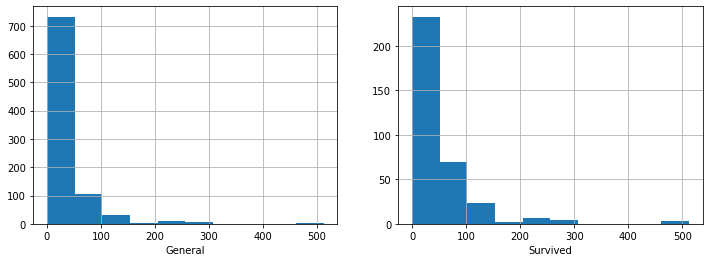

In [13]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(12,4))

axis1.set_xlabel('General')
df.Fare.hist(ax=axis1)
axis2.set_xlabel('Survived')
df[(df.Survived == 1)].Fare.hist(ax=axis2)

De forma esperada, a distribuição foi bastante alterada quando se considerou somente os sobreviventes, dado o que já havia sido comentado na análise do atributo **Pclass**.

Chegando ao atributo **Cabin**, verifica-se uma alta taxa de dados faltantes, cerca de 77%, inviabilizando a utilização do atributo que deverá ser removido do modelo.

In [14]:
print("Dados faltantes no atributo Cabin:" , len(df[df.Cabin.isna()])/len(df.Cabin))

Dados faltantes no atributo Cabin: 0.7710437710437711


Quanto ao atributo **Age**, iniciamos plotando a ditribuição entre os sobreviventes e os não sobreviventes. 

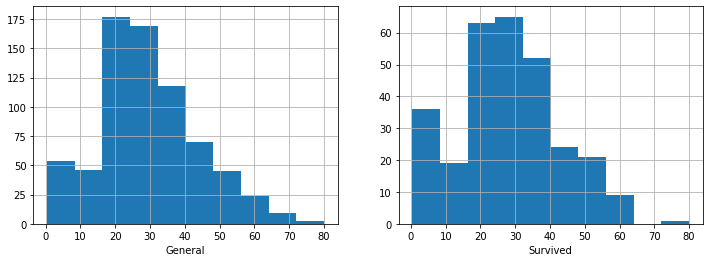

In [15]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(12,4))

axis1.set_xlabel('General')
df.Age.hist(ax=axis1)
axis2.set_xlabel('Survived')
df[(df.Survived == 1)].Age.hist(ax=axis2)

A distribuição da frequencia dos valores do atributo entre os sobreviventes, indica uma concentração nos passageiros com idade mais baixa, fato influenciado pela questão de priorizar mulheres e crianças em uma emergência. Outro fato que chama a atenção é que o passageiro com maior idade, sobreviveu.

Há que se destacar que o atributo não apresenta todos os valores preenchidos.

In [16]:
df[df.Age.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


São 177 registros com a falta da informação. É uma informação relevante para o modelo. Há que se definir então uma estratégia para preencher os valores faltantes. Essa questão será explorada na próxima seção;

##**3. Preparação dos dados para a criação dos modelos**

Com os dados já conhecidos, chega o momento de prepará-los para a modelagem. Essa etapa envolve as tarefas de preenchimento de valores faltantes, tratamento de dados categóricos, normalização de atributos numéricos, entre outras.

#### Eliminação de dados faltantes

Conforme já comentado, os atributos **Age**, **Cabin**, **Fare** e **Embarked**, precisarão de algum tratamento para imputar dados.

Cabe sempre lembrar as opções para o tratamento dos dados faltantes:
* Preencher esses valores arbitrariamente (média, mediana, valor mais frequente);
* Excluir o registro inteiro.

Segue a quantidade de dados faltantes no conjunto de treinamento:


In [17]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Dada a pequena quantidade de dados faltantes no atributo **Embarked** será utilizado valor mais frequente, no caso, o porto `S`.

O atributo **Fare** não aparece faltando, entretanto, como havia sido detectado no conjunto de dados geral, o registro com o valor faltante foi direcionado para os dados de teste, logo, há que se definir uma estratégia para ele também. No caso, pode-se optar pela média.

O atributo **Cabin** conforme já diagnosticado, deve ser removido do modelo na etapa seguinte.

O atributo **Age** merece uma atenção especial pela importância detectada na seção anterior. A estratégia para o preenchimento dos registros poderia ser utilizar a média dos valores, entretanto, isso simplificaria demais o problema inserindo ruído, vista a amplitude [0 a 80] de valores possíveis no atributo. **Uma possibilidade seria a utilização do prefixo existente no nome de todos os passageiros e utilizar a média de cada categoria**. Assim o preenchimento seria mais customizado para cada situação, reduzindo o erro que será inserido.

Seguem o conteúdo do atributo **Name**:

In [18]:
df.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

Uma expressão regular poderia extrair o conteúdo imediatamente anterior ao ponto e incluir em um novo atributo do dataset.

In [19]:
# Expressão que extrai o texto imediatamente antes do ponto até um espaço.
df.Name.str.extract('([A-Za-z]+)\.')

,0
0,Mr
1,Mrs
2,Miss
3,Mrs
4,Mr
...,...
886,Rev
887,Miss
888,Miss
889,Mr


In [20]:
# Criação de uma coluna com a descrição do Título detectado no nome do passageiro 
df['Title'] = df.Name.str.extract('([A-Za-z]+)\.')

# Função que informa a média da idade segundo um título apresentado
def mean_age_of_title(title):
  return round(df[df.Title == title].Age.mean(), 0)

# Criação de mais um atributo para receber a idade média de determinado título
df['Mean_Age_Title'] = df.apply(lambda row: mean_age_of_title(row['Title']), axis = 1)

Passada essa definição, são criados os preenchedores dos valores: 

In [21]:
# Atributo Embarked
embarked_top = df['Embarked'].value_counts()[0]
df['Embarked'].fillna(embarked_top, inplace=True)

# fare
fare_mean = df['Fare'].mean()
df['Fare'].fillna(fare_mean, inplace=True)

# Atributo Age
df['Age'].fillna(df['Mean_Age_Title'], inplace=True)


#### Eliminação de atributos do modelo

Conforme já mencionado anteriormente, os atributos **Ticket** e **Cabin** devem ser excluídos devido à falta de utilidade. Também é um atributo que nada informa o **PassengerId**.

Além desses, também devem ser excluídos os atributos temporários **Title** e **Mean_Age_Title**, inclusive o atributo **Name** que já foi utilizado para o tratamento dos valores faltantes do atributo **Age**.

Para a exclusão desses 6 atributos será criada uma função:

In [22]:
def exclude_atributes(df=df, atributes = ['Ticket', 'Cabin', 'PassengerId', 'Title', 'Mean_Age_Title', 'Name' ]):
  df.drop(atributes, axis=1, inplace=True)

In [23]:
exclude_atributes()

In [24]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')